# Test convergence of system cost MC estimate from simulator

In [1]:
import os
import csv
import json
import copy
import time
import random
import numpy as np
import matplotlib.pyplot as plt

import inspect
from tqdm import tqdm
from multiprocessing import Pool

In [2]:
# set up test parameters
dataset_dir = os.path.join('data','A37_analysis_test') # dataset directory
schema_path = os.path.join(dataset_dir,'schema.json')
opex_factor = 10
pricing_dict = {'carbon':5e-1,'battery':1e3,'solar':2e3}

with open(os.path.join(dataset_dir,'metadata_ext.json'),'r') as json_file:
    annex_defaults = json.load(json_file)

#ids = [0,3,9,11,12,15,16,25,26,32,38,44,45,48,49]
ids = [48]

base_kwargs = {
    'output_dir_path': dataset_dir,
    'building_names': ['UCam_Building_%s'%id for id in ids],
    'battery_energy_capacities': None,
    'battery_power_capacities': [annex_defaults["building_attributes"]["battery_power_capacities (kW)"][str(id)] for id in ids],
    'battery_efficiencies': None,
    'pv_power_capacities': None,
    'load_data_paths': ['UCam_Building_%s.csv'%id for id in ids],
    'weather_data_path': 'weather.csv',
    'carbon_intensity_data_path': 'carbon_intensity.csv',
    'pricing_data_path': 'pricing.csv',
    'schema_name': 'schema_temp'
}

In [3]:
# Set up probabilistic model of effiencies and take draws
n_draws = 500
mu = 0.85
sigma = 0.1
eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_draws,len(ids)))
eta_samples = np.clip(eta_samples,0,1)

In [4]:
# Define multiprocessing helper functions.

n_processes = min(25,os.cpu_count()//2) # for some reason more than this is an issue ...? Maybe a memory issue

def multi_proc_constr_and_eval_system(args_list):

    from sys_eval import construct_and_evaluate_system

    return construct_and_evaluate_system(*args_list)

def parallel_task(func, iterable, n_procs):
    # Adapted from solution to https://stackoverflow.com/questions/47313732/jupyter-notebook-never-finishes-processing-using-multiprocessing-python-3/47374811
    # NOTE: this function must be in the notebook
    # NOTE: in this workaround, the function passed to `parallel_task`
    # must do all of the importing it needs, and unwrap the arguments
    # (only a single argument can be passed)

    temp_path = f'./tmp_func.py'
    with open(temp_path, 'w') as file:
        file.write(inspect.getsource(func).replace(func.__name__, "task"))

    from tmp_func import task

    if __name__ == '__main__':
        pool = Pool(processes=n_procs)
        res = list(tqdm(pool.imap(task, iterable), total=len(iterable)))
        pool.close()
        os.remove(temp_path)
        return res
    else:
        raise "Not in Jupyter Notebook"

In [5]:
direct_MC_op_result = {'battery_capacities':[1377.9],'solar_capacities':[1023.8]} # from direct_MC_op.py

In [6]:
# Compute MC estimate of true system cost
mproc_args_list = [[direct_MC_op_result['battery_capacities'],direct_MC_op_result['solar_capacities'],eta_samples[n],base_kwargs,pricing_dict,opex_factor,n] for n in range(n_draws)]
cost_evals = parallel_task(multi_proc_constr_and_eval_system, mproc_args_list, n_procs=n_processes)

100%|██████████| 500/500 [35:52<00:00,  4.31s/it]  


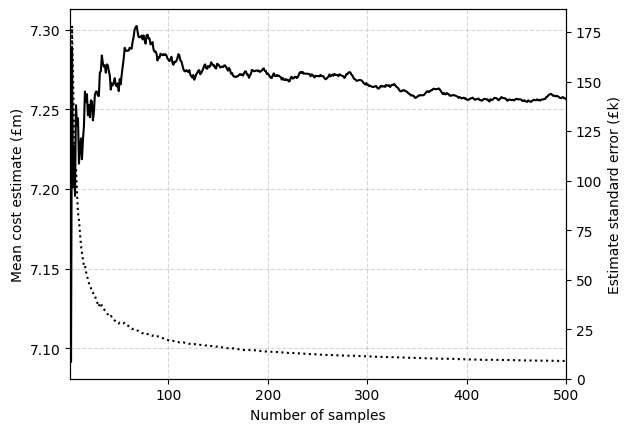

In [7]:
# Plot convergence of MC estimate
MC_means = [np.mean(cost_evals[:i]) for i in range(1,n_draws+1)]
MC_stnd_errors = [np.std(cost_evals[:i])/np.sqrt(i) for i in range(2,n_draws+1)]

fig,ax = plt.subplots()
ax.set_xlim(1,n_draws)
ax.set_xlabel("Number of samples")
ax.grid(True,'major',alpha=0.5,linestyle='--')

ax.plot(range(1,n_draws+1),np.array(MC_means)/1e6,'-k')
ax.set_ylabel('Mean cost estimate (£m)')
#ax.set_ylim(0)

# min_ax = ax.twinx()
# min_ax.plot(range(2,n_draws+1),(np.array(MC_stnd_errors)/MC_means[-1])*100,'k--')
# min_ax.set_ylabel('Estimate standard error (% of final mean)')
# min_ax.set_ylim(0)

min_ax_abs = ax.twinx()
min_ax_abs.plot(range(2,n_draws+1),np.array(MC_stnd_errors)/1e3,'k:')
min_ax_abs.set_ylabel('Estimate standard error (£k)')
min_ax_abs.set_ylim(0)

plt.show()

To find a reasonable value of MC estimates needed we could repeat this analysis for a number of seeds and find the average number of samples needed for the standard error to fall below a given threshold, e.g. £100k, are initially peaking

In [8]:
print(cost_evals)
print(MC_means)
print(MC_stnd_errors)

[7252707.36441786, 6930241.52534546, 7683255.522309843, 6938160.041990656, 7332043.885219667, 7037893.753104508, 7594419.5755201215, 7152223.668020859, 7280523.977214014, 6958757.137764428, 7327279.868614603, 7294930.508789556, 7061862.09511822, 7389887.121280541, 7360801.227661366, 7585659.034815959, 7147514.767748175, 7344929.346003665, 7007749.111354783, 7375966.319993741, 7090287.197834067, 7480008.743120027, 7238419.580763105, 6970739.555328267, 7370813.371213388, 7533485.306805458, 7310945.06471123, 7264267.191769923, 7188344.867199862, 7249113.816274095, 7719258.692094941, 7293884.964923476, 7602515.051662598, 7119925.1724114455, 7202748.230113238, 7306329.958469863, 7108556.446801883, 7468362.289183108, 7259979.37980557, 7137814.330486063, 7153989.246174956, 6899234.977426476, 7432917.545005328, 7209215.561841801, 7340319.079780599, 7398812.138274489, 7063788.304322096, 7224850.548242067, 7360046.459285731, 7020401.041627749, 7648364.949192561, 7099039.2447808925, 7592301.86501

Instead of that, lets shuffle the samples we've already taken

In [9]:
shuffle_costs = copy.deepcopy(cost_evals)
n_shuffles = 100
threshold = np.mean(cost_evals)*5e-3 # 50e3 # threshold on standard error

thresholds = [np.mean(cost_evals)*1e-2,np.mean(cost_evals)*5e-3,np.mean(cost_evals)*2.5e-3,75e3,50e3,25e3]
threshold_results = {}

for threshold in thresholds:

    req_samples = []

    for _ in range(n_shuffles):
        random.shuffle(shuffle_costs)
        shuffle_stnd_errors = [np.std(shuffle_costs[:i])/np.sqrt(i) for i in range(1,n_draws+1)]

        ind = 0
        for j,val in enumerate(reversed(shuffle_stnd_errors)): # work backwards through stnd error values
            if val > threshold: # when std error first rises above threshold
                ind = n_draws - j # get index of position after this in forwards list
                break
        req_samples.append(ind+1) # report number of samples needed to stably drop below threshold on stnd error
    
    threshold_results[threshold] = np.mean(req_samples)

In [10]:
print(req_samples)
print(np.mean(req_samples))

[72, 61, 62, 53, 70, 60, 67, 54, 52, 76, 61, 48, 76, 54, 64, 71, 57, 60, 54, 51, 56, 56, 57, 45, 68, 69, 56, 70, 79, 66, 59, 65, 66, 42, 72, 73, 74, 64, 70, 60, 66, 72, 68, 56, 72, 36, 68, 59, 64, 68, 63, 49, 62, 60, 57, 58, 60, 71, 70, 59, 59, 57, 65, 64, 44, 39, 58, 74, 69, 62, 69, 68, 69, 61, 57, 55, 70, 68, 66, 80, 83, 73, 65, 77, 55, 57, 59, 72, 59, 70, 51, 59, 63, 57, 63, 63, 80, 63, 48, 68]
62.67


In [11]:
print(threshold_results)

{72565.17545316057: 6.93, 36282.587726580285: 30.68, 18141.293863290142: 119.67, 75000.0: 6.69, 50000.0: 15.02, 25000.0: 62.67}


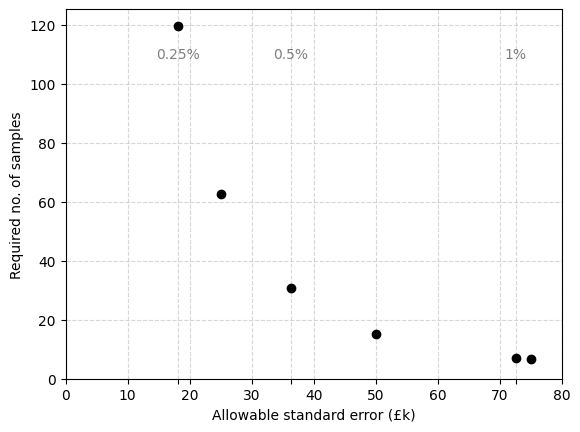

In [12]:
extra_ticks = [t/1e3 for t in thresholds[:3]]
extra_labels = ['1%','0.5%','0.25%']

plt.plot(np.array(list(threshold_results.keys()))/1e3,threshold_results.values(),'ko')
plt.xlabel("Allowable standard error (£k)")
plt.ylabel("Required no. of samples")
plt.xlim(0)
plt.ylim(0)
plt.grid(True,'major',alpha=0.5,linestyle='--')
plt.xticks(list(plt.xticks()[0]) + extra_ticks, labels=plt.xticks()[1] + ['']*3)
for tick,label in zip(extra_ticks,extra_labels):
    plt.text(tick,110,label,alpha=0.5,ha='center',va='center')
plt.show()

Try replotting the MC estimate convergence for different shuffles of the data

In [27]:
random.shuffle(shuffle_costs)
shuffle_MC_means = [np.mean(shuffle_costs[:i]) for i in range(1,n_draws+1)]
shuffle_MC_stnd_errors = [np.std(shuffle_costs[:i])/np.sqrt(i) for i in range(2,n_draws+1)]

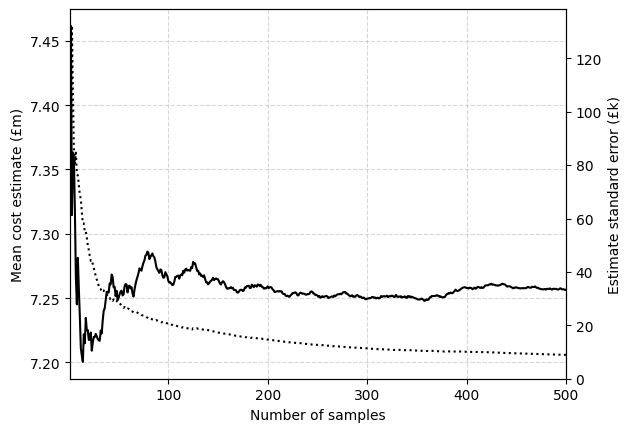

In [28]:
fig,ax = plt.subplots()
ax.set_xlim(1,n_draws)
ax.set_xlabel("Number of samples")
ax.grid(True,'major',alpha=0.5,linestyle='--')

ax.plot(range(1,n_draws+1),np.array(shuffle_MC_means)/1e6,'-k')
ax.set_ylabel('Mean cost estimate (£m)')
#ax.set_ylim(0)

# min_ax = ax.twinx()
# min_ax.plot(range(2,n_draws+1),(np.array(MC_stnd_errors)/MC_means[-1])*100,'k--')
# min_ax.set_ylabel('Estimate standard error (% of final mean)')
# min_ax.set_ylim(0)

min_ax_abs = ax.twinx()
min_ax_abs.plot(range(2,n_draws+1),np.array(shuffle_MC_stnd_errors)/1e3,'k:')
min_ax_abs.set_ylabel('Estimate standard error (£k)')
min_ax_abs.set_ylim(0)

plt.show()

It's looking like 100 samples is a more appropriate value from the visual convergence of the estimates - this seems to be around where they start stabalising